## NHANES - DATA Ingestion and Data Cleaning and Data Wrangling

- Load raw datasets (raw datasets with specific column fields) and save as interim csv file.
- Explore interim raw data 
- Clean datasets
- Explore cleaned data
- Save cleaned datasets 
- Done feature engineering
- Save processed datasets

## 1. Import required Libraries

***Project Initialization: Preparing the Environment and Loading Tools***

To begin, I set up the environment by importing all the necessary Python libraries, including tools for data handling (pandas, numpy), visualization (matplotlib, seaborn), and working with file paths (pathlib). I also added the project’s root folder to the system path so I can import custom modules from the scripts directory.

After that, I brought in several custom functions for loading, cleaning, and analyzing the data, as well as configuration settings like folder paths. I also made sure all the required directories (like processed data and plots) exist using the ensure_directories() function. Finally, I loaded some utility functions to help with exploring and formatting data.

Everything's now ready to start working with the NHANES datasets and USDA ARS FPED dataset.

In [1]:
# 1. Setup environment and imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# --- Add project root (parent of 'scripts') to sys.path ---
current_dir = Path().resolve()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import custom modules
from scripts.data_loading import process_datasets 
from scripts.data_cleaning import clean_datasets
from scripts.calculating_usda_hei_score import calculate_hei_scores
from scripts.config import PROCESSED_DATA_DIR, ensure_directories, PLOTS_DIR

# Ensure all necessary directories exist
ensure_directories()

# Import helper Functions
from scripts.utils import explore_data , pretty_path

print("Setup complete.")

Project directories are ready.
Setup complete.


## 2. DATA INGESTION

### STEP 1:  Load raw NHANES datasets with specific columns and saved it in interim csv file

***Loading Raw NHANES Data Files***

This section pulls in the original NHANES datasets using a custom process_datasets() function. The data is stored as a dictionary of DataFrames, each labeled by its dataset name, making it easier to explore and process later on.

In [2]:
# Load raw NHANES datasets
print("Loading raw datasets...")
interim_data =  process_datasets()

# raw_data is a dictionary of DataFrames keyed by dataset name
print(f"Loaded raw datasets: {list(interim_data.keys())}") 

Loading raw datasets...
Starting dataset validation...
File found for: DEMO_L
Successfully read DEMO_L as .xpt with pandas. Rows: 11933
File found for: PAQ_L
Successfully read PAQ_L as .xpt with pandas. Rows: 8153
File found for: SLQ_L
Successfully read SLQ_L as .xpt with pandas. Rows: 8501
File found for: DR1TOT_L
Successfully read DR1TOT_L as .xpt with pandas. Rows: 8860
File found for: DR1IFF_L
Successfully read DR1IFF_L as .xpt with pandas. Rows: 100116
File found for: HIQ_L
Successfully read HIQ_L as .xpt with pandas. Rows: 11933
File found for: BMX_L
Successfully read BMX_L as .xpt with pandas. Rows: 8860
File found for: BPXO_L
Successfully read BPXO_L as .xpt with pandas. Rows: 7801
File found for: TCHOL_L
Successfully read TCHOL_L as .xpt with pandas. Rows: 8068
File found for: GLU_L
Successfully read GLU_L as .xpt with pandas. Rows: 3996
File found for: DIQ_L
Successfully read DIQ_L as .xpt with pandas. Rows: 11744
File found for: MCQ_L
Successfully read MCQ_L as .xpt with pan

### STEP 2: Explore interim raw data

***Getting Familiar with the Data***

I started by loading the raw NHANES datasets and taking a first look around — just to see what kind of data I’m dealing with. This step helps me get a sense of the structure, spot any issues, and figure out what kind of cleaning or prep might be needed next.

In [3]:
# Explore interim raw data 
print("Exploring interim raw datasets...")
explore_data(interim_data)

Exploring interim raw datasets...

--- Exploring DEMO_L ---
Shape: (11933, 10)

First 5 rows:
       SEQN  RIAGENDR  RIDAGEYR  RIDRETH3  DMDEDUC2  INDFMPIR      WTINT2YR  \
0  130378.0       1.0      43.0       6.0       5.0      5.00  50055.450807   
1  130379.0       1.0      66.0       3.0       5.0      5.00  29087.450605   
2  130380.0       2.0      44.0       2.0       3.0      1.41  80062.674301   
3  130381.0       2.0       5.0       7.0       NaN      1.53  38807.268902   
4  130382.0       1.0       2.0       3.0       NaN      3.60  30607.519774   

       WTMEC2YR  SDMVSTRA  SDMVPSU  
0  54374.463898     173.0      2.0  
1  34084.721548     173.0      2.0  
2  81196.277992     174.0      1.0  
3  55698.607106     182.0      2.0  
4  36434.146346     182.0      2.0  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      

## 3.Data Cleaning

### STEP 1:  Clean the Data 

***Cleaning the Data***

I moved on to cleaning the raw datasets to make sure everything is consistent and ready for analysis. This step involved fixing errors, handling missing values, and organizing the data properly. After cleaning, I checked to confirm all the datasets were processed and ready to go.

In [4]:
# Clean interim raw datasets
print("Cleaning datasets...")
cleaned_data = clean_datasets(interim_data)
print(f"Cleaned datasets: {list(cleaned_data.keys())}")

Cleaning datasets...
Cleaning dataset: DEMO_L
Cleaning process begins
DEMO_L dataset rows and columns before cleaning: (11933, 10)
Dropped rows with missing age...
Removed people under 20 years old...
Dropping rows missing gender, race, strata, or PSU...
Mapping gender, race, and education level to text...
Replacing weird tiny float values (e.g., 5.39e-79) with NaN...
Imputing missing poverty_income_ratio (PIR) within education_level + race_ethnicity groups...
Imputed PIR: 1388 filled, 0 still missing
Removing missing and invalid sample weights
Checking for missing interview sample weight...
DEMO_L dataset rows and columns after cleaning: (6064, 11)
Saved cleaned data to: data\clean\demo_l_clean.csv
Cleaning dataset: SLQ_L
Cleaning SLQ_L dataset begins
Dataframe shape before cleaning: (8501, 3)
Missing values before cleaning:
Missing values in dataset: SLQ_L
participant_id        0
sleep_weekday_hr    113
sleep_weekend_hr    114
dtype: int64
Validating sleep hour values...
Calculating 

### STEP 2: Explore cleaned data

***Checking the Cleaned Data***

After cleaning, I took a close look at the cleaned datasets to understand what the data looks like now. This helped me verify that the cleaning worked as expected and gave me a good feel for the data before starting the analysis.

In [5]:
# Explore cleaned data 
print("Exploring cleaned datasets...")
explore_data(cleaned_data)

Exploring cleaned datasets...

--- Exploring DEMO_L ---
Shape: (6064, 11)

First 5 rows:
  participant_id  gender  age      race_ethnicity            education_level  \
0         130378    Male   43  Non-Hispanic Asian  College graduate or above   
1         130379    Male   66  Non-Hispanic White  College graduate or above   
2         130380  Female   44      Other Hispanic            High school/GED   
8         130386    Male   34    Mexican American     Some college/AA degree   
9         130387  Female   68  Non-Hispanic White  College graduate or above   

   poverty_income_ratio  interview_sample_weight  exam_sample_weight  strata  \
0                  5.00             50055.450807        54374.463898   173.0   
1                  5.00             29087.450605        34084.721548   173.0   
2                  1.41             80062.674301        81196.277992   174.0   
8                  1.33             30995.282610        39988.452940   179.0   
9                  1.32       

## 4. Data Wrangling

### STEP 1: Feature Engineering

***Feature Engineering for Health Data***

I implemented a comprehensive feature engineering function that enriches multiple NHANES datasets by categorizing key health variables. This includes classifying poverty income ratio, physical activity levels, sleep patterns, blood pressure, obesity status, cholesterol levels, and glucose categories. Additional diabetes and cardiovascular disease features are also engineered when their respective data is present. The function ensures clean integration of flags and transformations, preparing the data for robust downstream analysis.

In [6]:
# Feature engineering

# Import functions
from scripts.feature_engineering import (
    categorize_activity_level, categorize_sleep, get_pir_category, flag_obesity, categorize_bp,
    cholesterol_category, glucose_category, glucose_flags, engineer_diq_features, engineer_mcq_features
)
def engineer_features(cleaned_data):
    if 'DEMO_L' in cleaned_data and not cleaned_data['DEMO_L'].empty:
        cleaned_data['DEMO_L']["pir_category"] = cleaned_data['DEMO_L']["poverty_income_ratio"].apply(get_pir_category)
    
    if 'PAQ_L' in cleaned_data and not cleaned_data['PAQ_L'].empty:
        cleaned_data['PAQ_L']['activity_level'] = cleaned_data['PAQ_L']['total_weekly_min'].apply(categorize_activity_level)

    if 'SLQ_L' in cleaned_data and not cleaned_data['SLQ_L'].empty:
        cleaned_data['SLQ_L']['sleep_category'] = cleaned_data['SLQ_L']['sleep_avg_hr'].apply(categorize_sleep)

    if 'BPXO_L' in cleaned_data and not cleaned_data['BPXO_L'].empty:
        cleaned_data['BPXO_L']['bp_category'] = cleaned_data['BPXO_L'].apply(
            lambda row: categorize_bp(row['systolic_avg'], row['diastolic_avg']), axis=1
        )

    if 'BMX_L' in cleaned_data and not cleaned_data['BMX_L'].empty:
        cleaned_data['BMX_L']['obese'] = cleaned_data['BMX_L']['bmi'].apply(flag_obesity).astype(int)

    if 'TCHOL_L' in cleaned_data and not cleaned_data['TCHOL_L'].empty:
        cleaned_data['TCHOL_L']['cholesterol_category'] = cleaned_data['TCHOL_L']['total_cholesterol'].apply(cholesterol_category)

    if 'GLU_L' in cleaned_data and not cleaned_data['GLU_L'].empty:
        df_glu = cleaned_data['GLU_L'].copy()
        
        # Add glucose category
        df_glu['glucose_category'] = df_glu['fasting_glucose_mg_dl'].apply(glucose_category)
        
        # Compute flags only once
        flags_df = df_glu['fasting_glucose_mg_dl'].apply(glucose_flags).apply(pd.Series)
        flags_df.columns = ['hypoglycemia_flag', 'hyperglycemia_flag']
        
        # Drop existing flag columns if they exist (to avoid duplicates)
        df_glu = df_glu.drop(columns=[col for col in df_glu.columns if col in ['hypoglycemia_flag', 'hyperglycemia_flag']], errors='ignore')
        
        # Concatenate cleanly
        df_glu = pd.concat([df_glu, flags_df], axis=1)
        
        # Add log column
        df_glu['log_fasting_glucose_mg_dl'] = np.log(df_glu['fasting_glucose_mg_dl'].clip(lower=1))
        
        # Assign back
        cleaned_data['GLU_L'] = df_glu

     # Add diabetes features if 'DIQ_L' dataframe exists
    if 'DIQ_L' in cleaned_data and not cleaned_data['DIQ_L'].empty:
        cleaned_data['DIQ_L'] = engineer_diq_features(cleaned_data['DIQ_L'])

    # Add cardiovascular disease features if 'MCQ_L' dataframe exists
    if 'MCQ_L' in cleaned_data and not cleaned_data['MCQ_L'].empty:
        cleaned_data['MCQ_L'] = engineer_mcq_features(cleaned_data['MCQ_L'])

    return cleaned_data


***Applying Feature Engineering to NHANES Data***

I executed the feature engineering function on the cleaned NHANES datasets, first filtering out unnecessary keys to streamline processing. After applying the engineered transformations and categorizations, I confirmed the resulting dataset keys, ensuring that the processed data is ready for further analysis and modeling steps.

In [7]:
# Calling feature engineering 
print("Engineering features...")

# Filter out the unwanted keys BEFORE passing to the function
filtered_cleaned_data = {k: v for k, v in cleaned_data.items() if k not in ['DR1TOT_L', 'DR1IFF_L', 'FPED_1720']}

# Apply feature engineering
processed_data = engineer_features(filtered_cleaned_data)

# Show keys of processed data
print(f"Processed datasets: {list(processed_data.keys())}")


Engineering features...
Processed datasets: ['DEMO_L', 'SLQ_L', 'PAQ_L', 'HIQ_L', 'BMX_L', 'BPXO_L', 'TCHOL_L', 'GLU_L', 'DIQ_L', 'MCQ_L']


### STEP 2: Save processed data

***Saving Processed NHANES Data to CSV Files***

I saved all the processed datasets as CSV files in the designated folder. This ensures the data with new features is safely stored and ready for future analysis or sharing. All files were successfully saved.

In [8]:
#  Save processed data

def save_processed_data(processed_data: dict, folder_path=PROCESSED_DATA_DIR):
    folder_path.mkdir(parents=True, exist_ok=True) 

    for key, df in processed_data.items():
        file_path = folder_path / f"{key.lower()}_processed.csv"
        df.to_csv(file_path, index=False)
        print(f"Saved: {pretty_path(file_path)}")
print("Saving processed data...")
save_processed_data(processed_data)
print("All data saved.")


Saving processed data...
Saved: data\processed\demo_l_processed.csv
Saved: data\processed\slq_l_processed.csv
Saved: data\processed\paq_l_processed.csv
Saved: data\processed\hiq_l_processed.csv
Saved: data\processed\bmx_l_processed.csv
Saved: data\processed\bpxo_l_processed.csv
Saved: data\processed\tchol_l_processed.csv
Saved: data\processed\glu_l_processed.csv
Saved: data\processed\diq_l_processed.csv
Saved: data\processed\mcq_l_processed.csv
All data saved.


***Calculating HEI Scores from Dietary Data***

I ran the function calculate_hei_scores() to compute Healthy Eating Index (HEI) scores based on dietary intake data. This generated a DataFrame (diet_score_df) containing individual-level diet quality scores, which can be used for further nutritional assessment and analysis.

In [9]:
diet_score_df = calculate_hei_scores()

Merging NHANES Individual Foods with FPED using food codes...

------------Aggregate Nutrients and Energy by Participant------------------------

Mean HEI component scores and total:
hei_total_fruit           2.3
hei_whole_fruit           1.9
hei_total_veg             2.6
hei_greens_beans          1.4
hei_whole_grains          2.6
hei_dairy                 5.0
hei_total_protein         3.8
hei_sea_plant_protein     0.7
hei_fatty_acid            2.0
hei_refined_grains        6.3
hei_added_sugars          8.8
hei_sodium                5.3
hei_sat_fats              5.2
hei_score                47.9
dtype: float64
Saved cleaned data to: data\processed\hei2015_scores.csv


### STEP 3: Explore processed data

***Exploring Processed Diet Score Data***

I explored the merged and processed diet score dataset (diet_score_df) to understand its structure

In [10]:
# Explore and Understand the Processed Data
print("Exploring Merged diet score processed data..")
explore_data(diet_score_df)

Exploring Merged diet score processed data..

--- Exploring Dataset ---
Shape: (6739, 18)

First 5 rows:
   participant_id  total_diet_weight  food_item_weight diet_score_category  \
0          130378       61366.555827      6.750321e+05                Poor   
1          130379       34638.056480      5.888470e+05   Needs Improvement   
2          130380       84728.261560      1.101467e+06                Poor   
3          130381       61737.133446      1.049531e+06                Poor   
4          130382       75846.746917      9.101610e+05                Poor   

   hei_fatty_acid  hei_total_fruit  hei_whole_fruit  hei_total_veg  \
0             0.0              0.0         0.000000       5.000000   
1            10.0              5.0         4.979934       5.000000   
2             0.0              5.0         2.644737       4.121212   
3             0.0              5.0         5.000000       1.880438   
4             0.0              5.0         5.000000       0.522869   

   he

***Exploring and Understanding the individual Processed Data***

I took a close look at the processed datasets to get a clear picture of what the data looks like after cleaning and feature engineering. This helps me verify the changes and better understand the content before moving on to analysis.

In [11]:
# Explore and Understand the Processed Data
print("Exploring individual processed data..")
explore_data(processed_data)

Exploring individual processed data..

--- Exploring DEMO_L ---
Shape: (6064, 12)

First 5 rows:
  participant_id  gender  age      race_ethnicity            education_level  \
0         130378    Male   43  Non-Hispanic Asian  College graduate or above   
1         130379    Male   66  Non-Hispanic White  College graduate or above   
2         130380  Female   44      Other Hispanic            High school/GED   
8         130386    Male   34    Mexican American     Some college/AA degree   
9         130387  Female   68  Non-Hispanic White  College graduate or above   

   poverty_income_ratio  interview_sample_weight  exam_sample_weight  strata  \
0                  5.00             50055.450807        54374.463898   173.0   
1                  5.00             29087.450605        34084.721548   173.0   
2                  1.41             80062.674301        81196.277992   174.0   
8                  1.33             30995.282610        39988.452940   179.0   
9                  1.3

### STEP 4: Correlation heatmaps for each processed dataset

***Correlation Heatmaps for Processed Data***

I generated and saved correlation heatmaps for all processed datasets that have enough numeric columns. This gives a quick visual overview of how variables relate to each other within each dataset, helping to spot strong associations or potential issues before deeper analysis. The heatmaps are compiled into a single PDF for easy review.

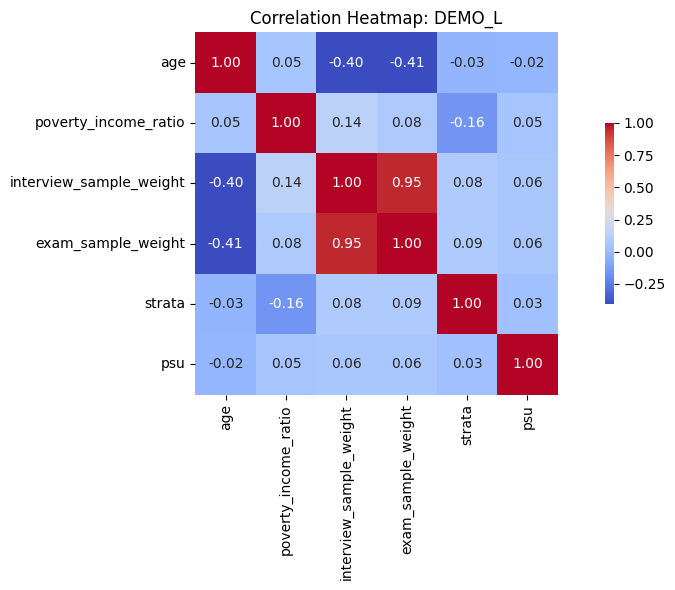

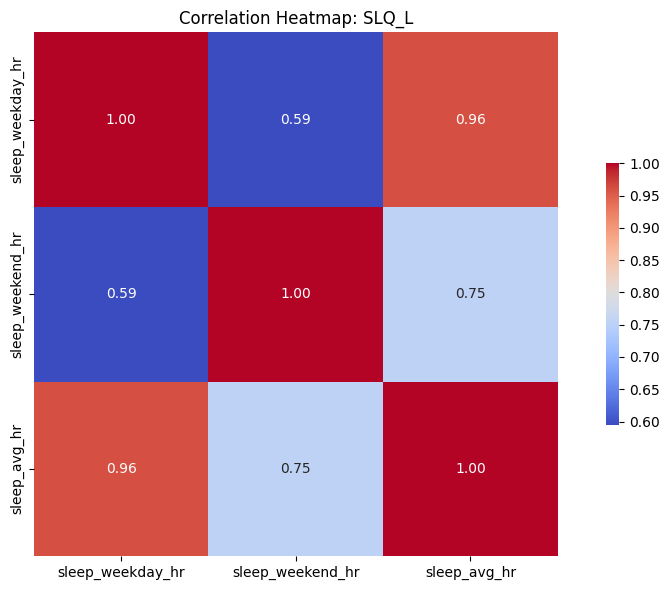

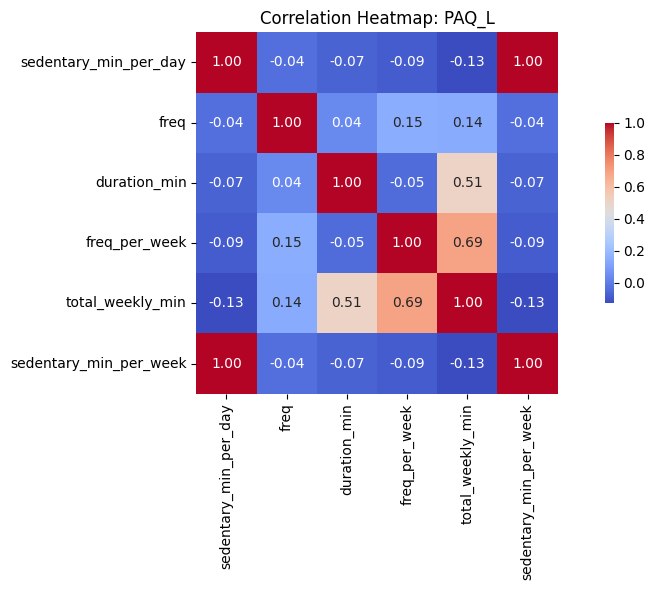

Skipping HIQ_L (not enough numeric columns).


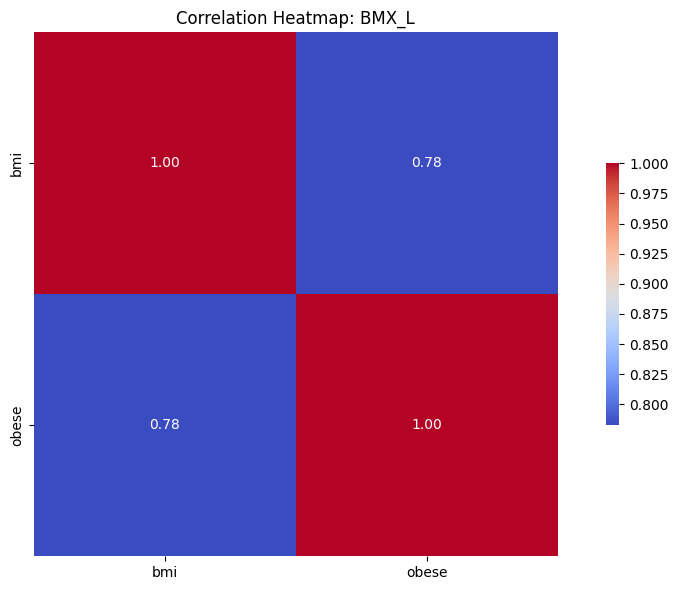

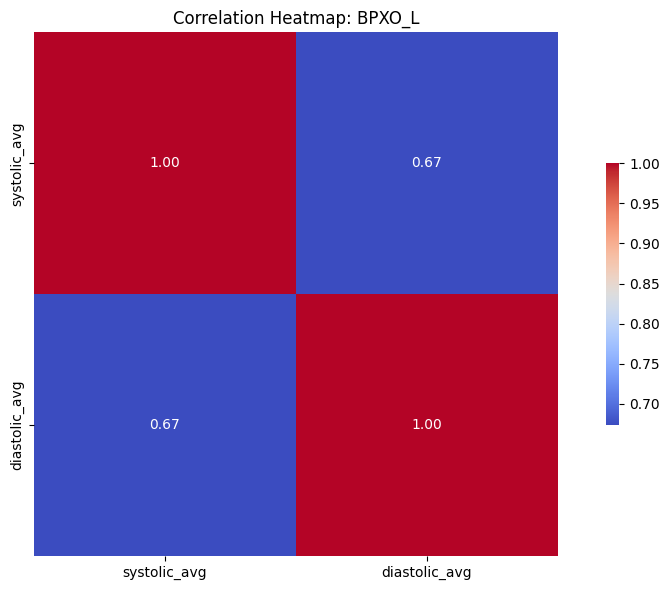

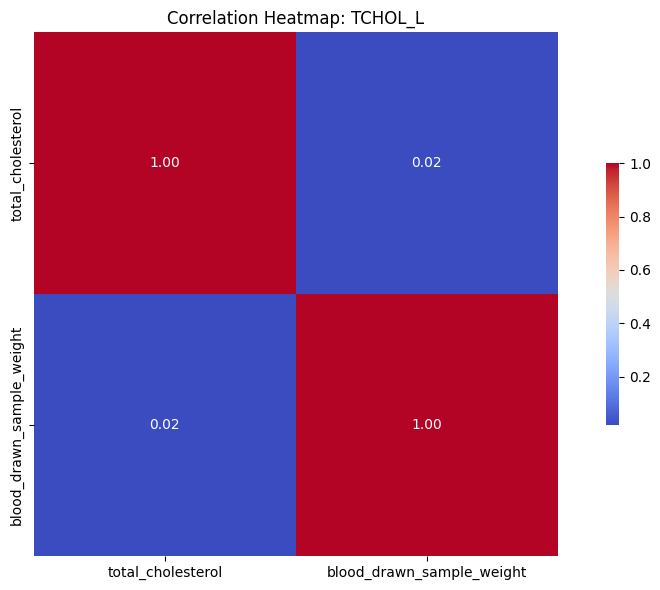

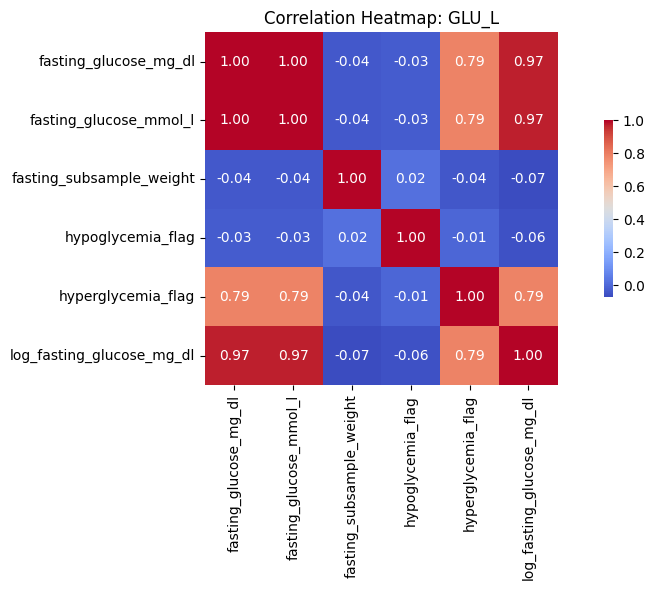

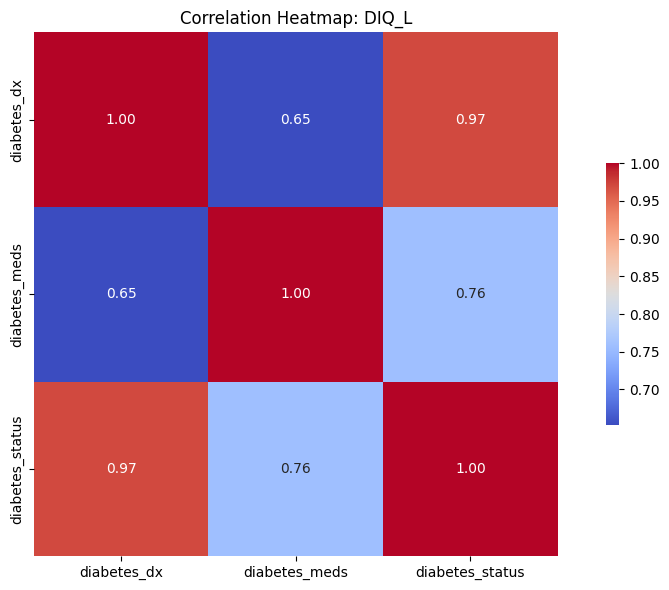

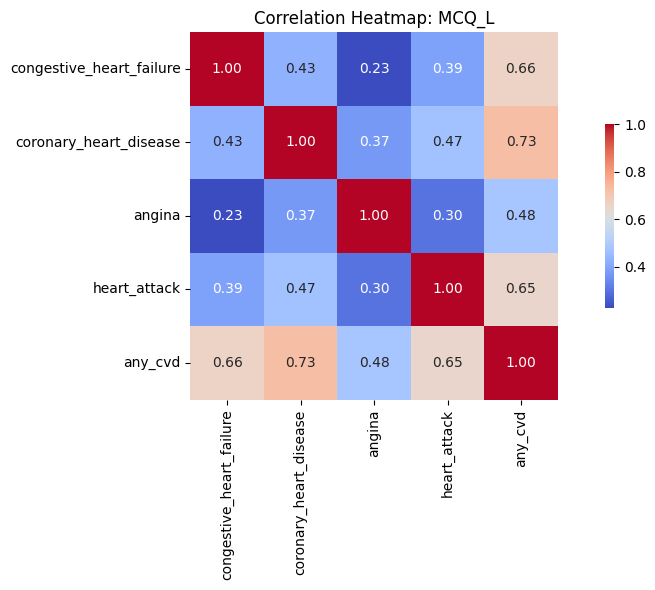

Saved all processed data heatmaps to outputs\plots\processed_data_correlation_heatmaps.pdf


In [12]:

# Create directory if missing
PLOTS_DIR.mkdir(parents=True, exist_ok=True)  

pdf_path = PLOTS_DIR / "processed_data_correlation_heatmaps.pdf"

with PdfPages(pdf_path) as pdf:
    for name, df in processed_data.items():
        numeric_df = df.select_dtypes(include=[np.number])
        if numeric_df.shape[1] < 2:
            print(f"Skipping {name} (not enough numeric columns).")
            continue

        plt.figure(figsize=(10, 6))
        sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .5})
        plt.title(f"Correlation Heatmap: {name}")
        plt.tight_layout()

        pdf.savefig()
        plt.show()
        plt.close()

print(f"Saved all processed data heatmaps to {pretty_path(pdf_path)}")

***Correlation Analysis of Diet Score Components***

I dropped non-numeric columns from the processed diet score dataset and computed the correlation matrix among numeric variables. The resulting heatmap visually displays relationships between dietary components and scores, highlighting which variables are strongly or weakly correlated. This insight can guide further analysis and feature selection.

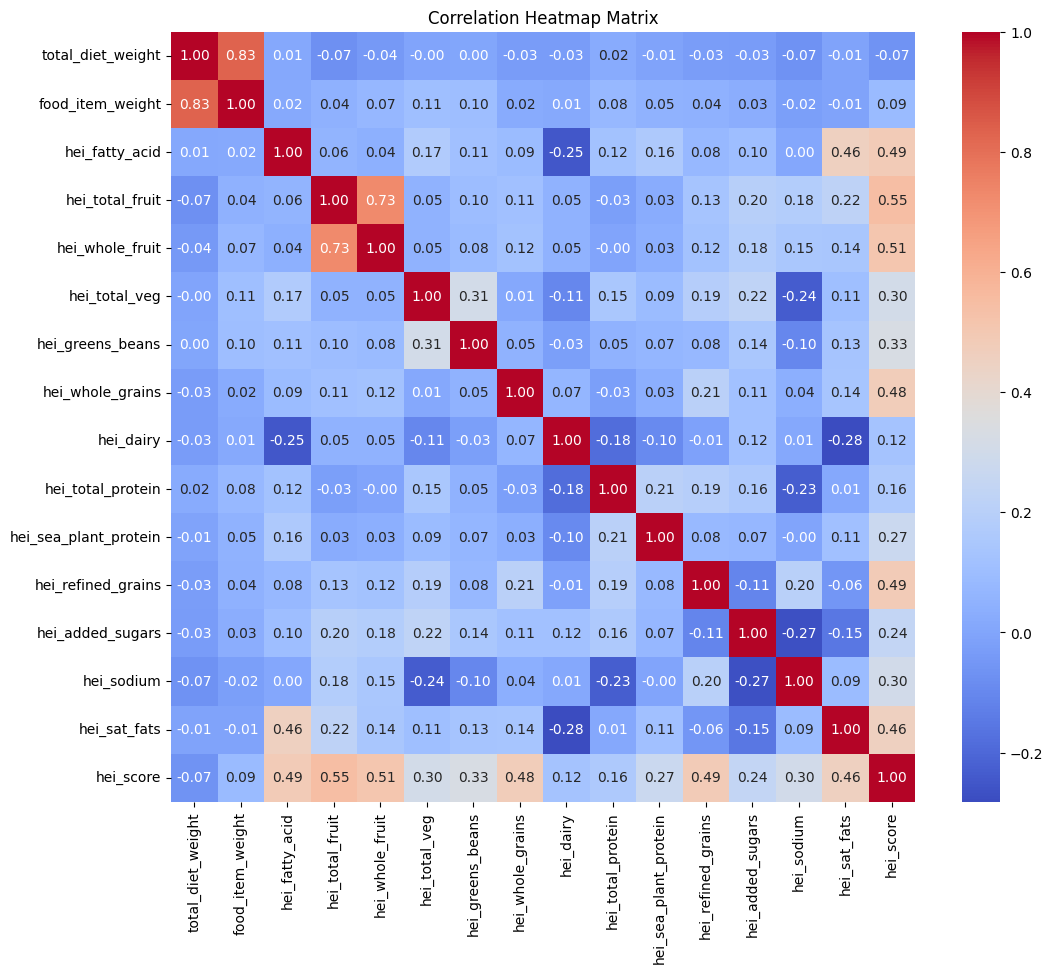

Diet score processed data heatmaps to outputs\plots\diet_score_correlation_heatmap.png


In [13]:
# Drop non-numeric columns 
df_numeric = diet_score_df.drop(columns=['participant_id', 'diet_score_category'])

# Compute correlation matrix
corr = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap Matrix')
plot_path = PLOTS_DIR/"diet_score_correlation_heatmap.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"Diet score processed data heatmaps to {pretty_path(plot_path)}")
